## France's high voltage network

Enedis (Electricity of France) recently (2018/05/16) released their networks as open geographical data. Let us try to load these data, plot and analyze them. We focus here on the high-voltage network: "lignes HTA" (the low-voltage network has also been made available as "lignes BT").

The network "lignes HTA" can be downloaded from the Enedis [data portal](https://data.enedis.fr/explore/dataset/reseau-hta/export/). Here we chose the GeoJSON file for the geographical data: reseau-hta.geojson (276.8 MB).

### Imports

In [1]:
%matplotlib inline
import numpy as np  # 1.14.3
import pandas as pd  # 0.23.0
import geopandas as gpd  # 0.3.0
from shapely.geometry import LineString, MultiLineString, Polygon, Point  # 1.6.4
from shapely.ops import linemerge
from shapely.wkt import loads
import osmnx as ox  # 0.8.1
import networkx as nx  # 2.1

### Load the data

It is also possible to download the data as a CSV file. The loading part with Pandas is really faster, however one has then to convert the geometry from a text format to a [shapely](https://shapely.readthedocs.io/en/latest/) geometric object.

In [2]:
%time hta = gpd.read_file('reseau-hta.geojson')

CPU times: user 52.5 s, sys: 1.83 s, total: 54.4 s
Wall time: 54.3 s


### Inspect the data

In [3]:
hta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1102066 entries, 0 to 1102065
Data columns (total 1 columns):
geometry    1102066 non-null object
dtypes: object(1)
memory usage: 8.4+ MB


In [4]:
hta.head(2)

,geometry
0,LINESTRING (0.275708182098627 47.1093150681570...
1,LINESTRING (0.495070935821371 46.9768407284384...


In [5]:
hta.crs

{'init': 'epsg:4326'}

So we have a geodataframe with a single column of 1102066 geometric entities. Note that GeoPandas took care of the coordinate reference system and reprojected the data to WGS 84 (World Geodetic System, EPSG4326). The original data was set in [RGF93](http://spatialreference.org/ref/epsg/rgf93-lambert-93/). Now let us look as the different geometry types:

In [6]:
hta['geom_type'] = hta.geometry.geom_type
hta.geom_type.value_counts()

LineString         1088976
MultiLineString      13090
dtype: int64

We have either `LineString` or `MultiLineString` objects. 

### Merge contiguous linestrings

By printing the first MultiLineString geometries, it appears that they look like two contiguous linestrings: the last point of the first line is the first point of the second line:

In [7]:
hta_multistrings = hta[hta.geom_type=='MultiLineString']
for i in range(5):
    print(hta_multistrings.iloc[i].geometry)

MULTILINESTRING ((5.685749462665464 45.4933603463797, 5.692583099821639 45.49271731503835), (5.692583099821639 45.49271731503835, 5.694533048595929 45.4927184074988))
MULTILINESTRING ((5.831607690311678 45.21450288626659, 5.831812772907658 45.21445980673872, 5.8318396154852 45.2145150611225), (5.8318396154852 45.2145150611225, 5.831845819911392 45.21452782324677))
MULTILINESTRING ((-0.828052361910001 46.6033272582639, -0.828082033002592 46.6033096416577), (-0.828082033002592 46.6033096416577, -0.828096135593586 46.60330126308212))
MULTILINESTRING ((3.408964986257356 45.96535585521448, 3.392933399314529 45.97251179704767), (3.392933399314529 45.97251179704767, 3.392922907219469 45.97251648455421))
MULTILINESTRING ((5.742027837681316 44.78330775954034, 5.741575221139959 44.78318747499932), (5.741575221139959 44.78318747499932, 5.741557476955085 44.78318275563127))


Let us merge these contiguous lines with `shapely.ops.linemerge` (which is not going to merge discontinuous LineStrings):

In [8]:
hta.loc[hta.geom_type=='MultiLineString', 'geometry'] = hta.loc[hta.geom_type=='MultiLineString', 'geometry'].map(linemerge)

In [9]:
hta['geom_type'] = hta.geometry.geom_type
hta.geom_type.value_counts()

LineString    1102066
dtype: int64

There is no more `MultiLineString` objects! They were all couples of contiguous lines. Why were they splitted into 2 different lines? I have no idea...

In [10]:
hta.drop(['geom_type'], axis=1, inplace=True)

### Sketch the data

CPU times: user 31.6 s, sys: 563 ms, total: 32.1 s
Wall time: 31.4 s


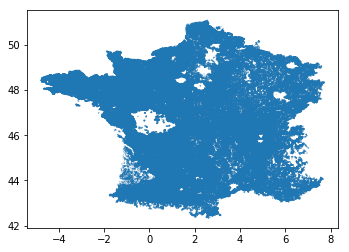

In [11]:
%time hta.plot()

We can see that some parts of France are managed by other companies (Enedis manages the public electricity distribution network for 95% of continental France). Let's zoom in the Auvergne-Rhône-Alpes region (GeoPandas has a very neat coordinate based indexing: the `.cx` indexer, which slices using a bounding box) and the Rhône department:

In [12]:
%time hta_ara = hta.cx[2.06:7.19, 44.12:46.8].copy(deep=True)

CPU times: user 38.3 s, sys: 95.2 ms, total: 38.3 s
Wall time: 38.3 s


In [13]:
print(len(hta_ara))

210905


The `.cx` indexer might not be using a spatial index as when calling `.sjoin`? Let us compare the elapsed time of each method.

First we start by creating a single row `GeoDataFrame` containing the Auvergne-Rhône-Alpes region geometry.

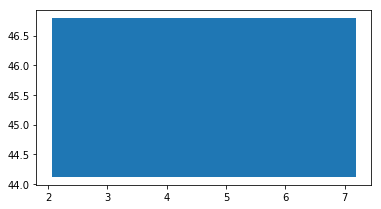

In [14]:
ara_geom = loads('POLYGON((2.06 46.8, 7.19 46.8, 7.19 44.12, 2.06 44.12, 2.06 46.8))')
ara_geom = gpd.GeoDataFrame(data=['blabla'], geometry=[ara_geom])
ara_geom.crs = {'init': 'epsg:4326'}
ara_geom.plot()

And perform the spatial join:

In [15]:
%time hta_ara_2 = gpd.sjoin(hta, ara_geom, how="inner", op='intersects')

CPU times: user 1min 4s, sys: 343 ms, total: 1min 4s
Wall time: 1min 4s


In [16]:
print(len(hta_ara_2))
del hta_ara_2

210905


Well `.sjoin` is actually slower that `.cx`... About twice as slow! So just use `.cx` for bounding box spatial selections...

CPU times: user 6.26 s, sys: 188 ms, total: 6.45 s
Wall time: 6.24 s


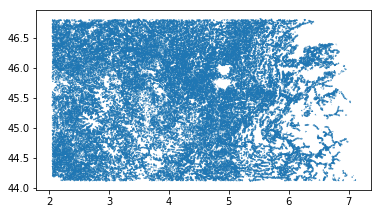

In [17]:
%time hta_ara.plot()

In [18]:
%time hta_rhone = hta_ara.cx[4.2436:5.1603, 45.454:46.3065].copy(deep=True)

CPU times: user 7.46 s, sys: 28.1 ms, total: 7.49 s
Wall time: 7.5 s


CPU times: user 717 ms, sys: 104 ms, total: 821 ms
Wall time: 675 ms


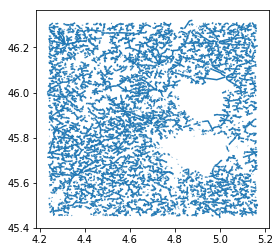

In [19]:
%time hta_rhone.plot()

### Compute network's length

In the EPSG4326 projection, coordinates correspond to angles: longitude and latitude. Thus the `LineString` length is not going to be helpful. Let us start by changing the CRS to a more appropriate one (EPSG:2154, RGF93 / Lambert-93), based on the metric system:

In [20]:
%time hta.to_crs(epsg=2154, inplace=True)

CPU times: user 32.4 s, sys: 192 ms, total: 32.5 s
Wall time: 32.5 s


In [21]:
%time hta['length'] = hta.geometry.length

CPU times: user 2.17 s, sys: 19.7 ms, total: 2.19 s
Wall time: 2.21 s


In [22]:
hta.head(2)

,geometry,length
index_left,,
0,LINESTRING (493450.4983000009 6671236.06979999...,316.533531
1,LINESTRING (509609.5552000029 6655978.72149999...,7.437865


In [23]:
hta.length.sum()

327098209.6888636

This means that we have 327098 km of high-voltage network here!

We convert the geometry back to the EPSG4326 CRS.

In [24]:
%time hta.to_crs(epsg=4326, inplace=True)

CPU times: user 34 s, sys: 152 ms, total: 34.1 s
Wall time: 34.1 s


### Creating a graph

Here we are going to convert the coordinates couple from float `(5.341875875765, 45.08582557887)` to strings while rounding to a given precision; e.g. 7 decimal digits: `'5.3418759, 45.0858256'`. This allows to make sure that points that are really close to each other, are going to be merged into a single one, in order for the graph to be connected as much as possible. However we don't want distinct points to be merged, which will happen if the precision is too low, e.g. 2 decimal digits.  
Well this is not very elegant but these strings are going to be used as a keys to get node IDs from the edge `LineString` end-point coordinates.

In [25]:
HTA_edges = hta_rhone.copy(deep=True)

In [26]:
prec = 7
HTA_edges["tail_coords"] = HTA_edges.geometry.map(lambda p: f'{np.round(p.coords[0][0], prec):.{prec}f}, {np.round(p.coords[0][1], prec):.{prec}f}')
HTA_edges["head_coords"] = HTA_edges.geometry.map(lambda p: f'{np.round(p.coords[-1][0], prec):.{prec}f}, {np.round(p.coords[-1][1], prec):.{prec}f}')

In [27]:
HTA_edges["tail_point"] = HTA_edges.geometry.map(lambda p: Point(p.coords[0]))
HTA_edges["head_point"] = HTA_edges.geometry.map(lambda p: Point(p.coords[-1]))

In [28]:
HTA_nodes = pd.concat([HTA_edges[["tail_coords", "tail_point"]].rename(columns={"tail_coords": "coords", "tail_point": "point"}), 
                       HTA_edges[["head_coords", "head_point"]].rename(columns={"head_coords": "coords", "head_point": "point"})], axis=0)
HTA_nodes.drop_duplicates(subset=['coords'], keep='first', inplace=True)

In [29]:
HTA_edges.drop(['tail_point', 'head_point'], axis=1, inplace=True)

In [30]:
HTA_nodes.reset_index(drop=True, inplace=True)
HTA_nodes["idx"] = HTA_nodes.index

In [31]:
HTA_edges = pd.merge(HTA_edges, HTA_nodes[['coords', 'idx']], left_on='tail_coords', right_on='coords', how='left')
HTA_edges.drop('coords', axis=1, inplace=True)
HTA_edges.rename(columns={'idx': 'tail'}, inplace=True)

In [32]:
HTA_edges = pd.merge(HTA_edges, HTA_nodes[['coords', 'idx']], left_on='head_coords', right_on='coords', how='left')
HTA_edges.drop('coords', axis=1, inplace=True)
HTA_edges.rename(columns={'idx': 'head'}, inplace=True)

Now that we have a graph with nodes and edges, we are going to change thses data so that we can convert them to a [NetworkX](https://networkx.github.io/) graph. For that, we use the nice [OSMnx](https://github.com/gboeing/osmnx) library, even if this network does not come from OSM (it will be avalaible on Open Street Map sometimes soon I guess). 

In [33]:
HTA_edges.drop(['tail_coords', 'head_coords'], axis=1, inplace=True)
HTA_edges.rename(columns={'tail': 'u', 'head': 'v'}, inplace=True)
HTA_edges["key"] = HTA_edges.index
HTA_edges = HTA_edges[HTA_edges.u != HTA_edges.v]  # here we remove loops from the graph

In [34]:
HTA_nodes['name'] = HTA_nodes.index.map(lambda i: "node"+str(i))
HTA_nodes.drop(['idx', 'coords'], axis=1, inplace=True)

In [35]:
HTA_nodes.rename(columns={'point': 'geometry'}, inplace=True)
crs = {'init': 'epsg:4326'}
HTA_nodes = gpd.GeoDataFrame(HTA_nodes, crs=crs, geometry=HTA_nodes.geometry)

In [36]:
HTA_nodes.gdf_name = "HTA_nodes"
HTA_nodes['osmid'] = HTA_nodes.index
HTA_nodes['x'] = HTA_nodes.geometry.x
HTA_nodes['y'] = HTA_nodes.geometry.y

Let's create the NetworkX graph:

In [37]:
G = ox.save_load.gdfs_to_graph(HTA_nodes, HTA_edges)

And plot it using OSMnx:

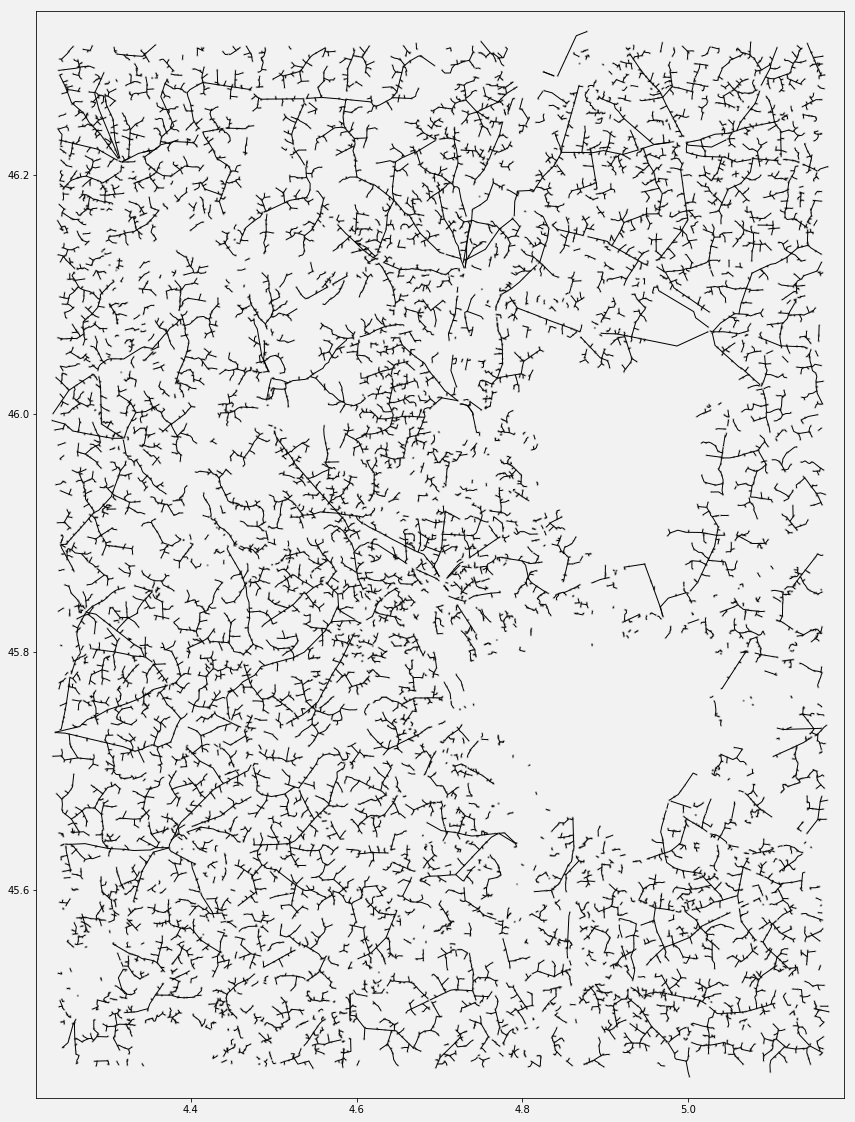

(<Figure size 1537.36x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f15c952a940>)

In [41]:
ox.plot_graph(G, fig_height=20, axis_off=False, node_color=(0.5, 0.5, 0.5), edge_color='black', 
              node_alpha=0.5, node_size=5, bgcolor=(0.95, 0.95, 0.95))

It seems that a lot of graph components are disconected, but this was already the case with the original data (at least visually). Maybe we should try to merge the high- and low-voltage networks?

Now we compute the largest connected component of the graph.

In [39]:
Gu = G.to_undirected()
Gu = max(nx.connected_component_subgraphs(Gu), key=len)

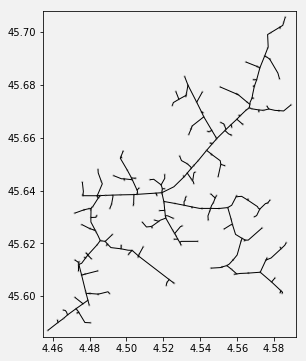

(<Figure size 479.796x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f15c94c0a90>)

In [40]:
ox.plot_graph(Gu, axis_off=False, node_color=(0.5, 0.5, 0.5), edge_color='black', 
              node_alpha=0.5, node_size=5, bgcolor=(0.95, 0.95, 0.95))

It is actually a very small part of the edges...